In [3]:
# 1. Setup and Imports
!pip install kaggle --quiet

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [6]:
# 2. Download Dataset (Kaggle)
# ==============================
# Make sure you have a kaggle.json API key (from Kaggle > Account > API > Create New Token)
# Upload kaggle.json before running below

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./data
!unzip -q ./data/chest-xray-pneumonia.zip -d ./data

base_dir = "./data/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# ==============================
# 3. Data Preprocessing
# ==============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="binary"
)

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode="binary"
)

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:24<00:00, 247MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s]
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
# 4. Model: Transfer Learning (ResNet50)
# ==============================
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# 5. Training
# ==============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 643ms/step - accuracy: 0.7246 - loss: 0.6246 - val_accuracy: 0.5000 - val_loss: 0.7755
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 600ms/step - accuracy: 0.7396 - loss: 0.5144 - val_accuracy: 0.5000 - val_loss: 0.7546
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.7516 - loss: 0.4666 - val_accuracy: 0.5000 - val_loss: 0.7581
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.7411 - loss: 0.4429 - val_accuracy: 0.5000 - val_loss: 0.7080
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.7397 - loss: 0.4328 - val_accuracy: 0.5000 - val_loss: 0.8744
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 616ms/step - accuracy: 0.7311 - loss: 0.4250 - val_accuracy: 0.5000 - val_loss: 0.7739
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.7318 - loss: 0.4150 - val_accuracy: 0.5000 - val_loss: 0.7546
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.7460 - los

In [9]:
# 6. Evaluate on Test Set
# ==============================
test_gen = val_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode="binary"
)

loss, acc = model.evaluate(test_gen)
print(f" Test Accuracy: {acc*100:.2f}%")

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.7914 - loss: 0.4587
 Test Accuracy: 80.29%


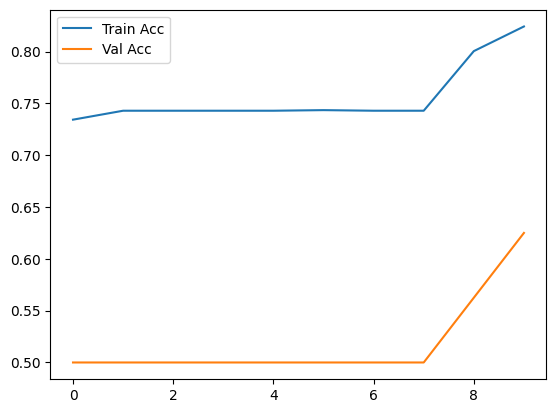

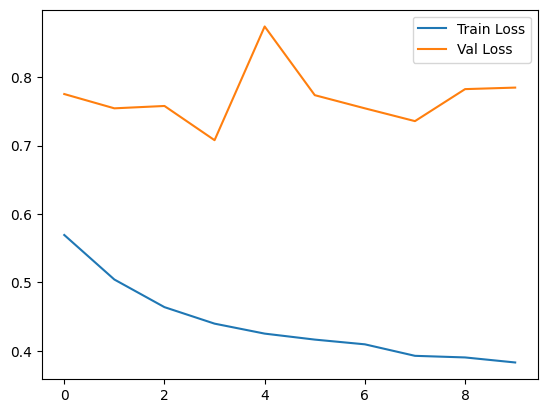

In [10]:
# 7. Plot Training Curves
# ==============================
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [11]:
# 8. Save Model
# ==============================
model.save("pneumonia_classifier.h5")
print(" Model saved as pneumonia_classifier.h5")

 Model saved as pneumonia_classifier.h5
